In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import random
import pandas as pd
np.random.seed(1234)

from utils import ThousandLandmarksDataset
from torch.utils.data import DataLoader
from utils import CROP_SIZE
from torchvision.transforms import transforms
import torch
from train import init_model
import tqdm
import seaborn as sns

In [2]:
train_path = './data/train/images/'
test_path = './data/test/images/'
train_img_names = [os.path.join(train_path, name) for name in os.listdir(train_path)]
test_img_names = [os.path.join(test_path, name) for name in os.listdir(test_path)]

def read_img(img_name):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [6]:
def get_img_shape(img_iter):
    height = {img.shape[0] for img in img_iter}
    weight = {img.shape[1] for img in img_iter}
    return height, weight

In [4]:
def get_data_shape(img_names):
    batch_size = 512
    length = len(img_names)
    height_set = set()
    weight_set = set()
    for left in tqdm.tqdm(range(0, length, batch_size)):
        right = min(length, left + batch_size)
        img_list = [read_img(i) for i in img_names[left:right]]
        h_update, w_update = get_img_shape(img_list)
        height_set.update(h_update)
        weight_set.update(w_update)
    return height_set, weight_set

In [7]:
train_shapes = get_data_shape(train_img_names)
test_shapes = get_data_shape(test_img_names)

100%|██████████| 32/32 [00:16<00:00,  1.95it/s]


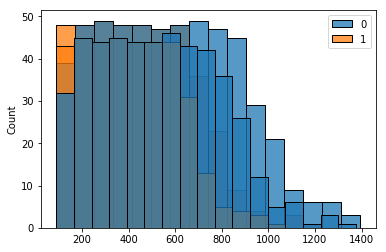

In [12]:
train_h, train_w = train_shapes
test_h, test_w = test_shapes
sns.histplot([list(train_h), list(train_w)])
sns.histplot([list(test_h), list(test_w)])

In [13]:
min(train_h), min(test_h), min(train_w), min(test_w)

(102, 102, 89, 90)

In [15]:
np.mean(list(train_h))

576.5535055350554

In [16]:
def get_shape_pd(img_names):
    batch_size = 512
    length = len(img_names)
    height_list = list()
    weight_list = list()
    for left in tqdm.tqdm(range(0, length, batch_size)):
        right = min(length, left + batch_size)
        img_list = [read_img(i) for i in img_names[left:right]]
        height = [img.shape[0] for img in img_list]
        weight = [img.shape[1] for img in img_list]
        height_list.extend(height)
        weight_list.extend(weight)
    shape_pd = pd.DataFrame({'height': height_list, 'weight': weight_list})
    return shape_pd

In [17]:
train_pd = get_shape_pd(train_img_names)
test_pd = get_shape_pd(test_img_names)

100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


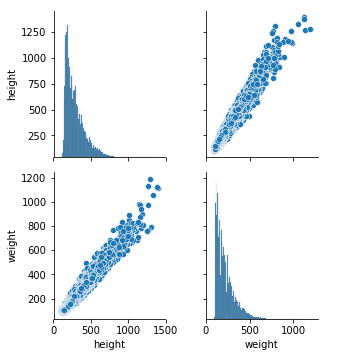

In [18]:
sns.pairplot(train_pd)

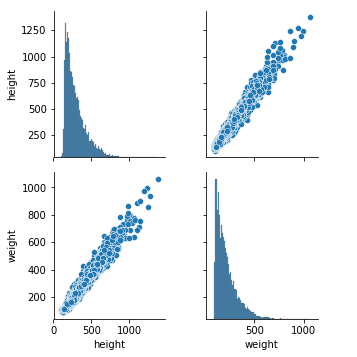

In [19]:
sns.pairplot(test_pd)

In [45]:
train_pd.quantile(0.33)

height    200.0
weight    148.0
Name: 0.3, dtype: float64

In [52]:
train_pd.quantile(0.66)

height    312.0
weight    231.0
Name: 0.66, dtype: float64

In [53]:
train_pd.quantile(1.0)

height    1395.0
weight    1192.0
Name: 1.0, dtype: float64

In [68]:
sum(train_pd.weight > 512) / len(train_pd)

0.01575

In [69]:
sum(test_pd.weight > 512) / len(test_pd)

0.017625

In [1]:
import timm

In [2]:
model = timm.create_model('efficientnet_b0', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /home/cherepaha/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [6]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequenti

In [11]:
model.blocks[-4:]

Sequential(
  (3): Sequential(
    (0): InvertedResidual(
      (conv_pw): Conv2d(40, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (conv_dw): Conv2d(240, 240, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=240, bias=False)
      (bn2): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): SiLU(inplace=True)
      (se): SqueezeExcite(
        (conv_reduce): Conv2d(240, 10, kernel_size=(1, 1), stride=(1, 1))
        (act1): SiLU(inplace=True)
        (conv_expand): Conv2d(10, 240, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_pwl): Conv2d(240, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): InvertedResidual(
      (conv_pw): Conv2d(80, 480, kernel_size=(1, 1), stride=(1, 1), bias=F